In [1]:
#utils.py

In [1]:
"""
You can add your own functions here according to your decision tree implementation.
There is no restriction on following the below template, these fucntions are here to simply help you.
"""

import pandas as pd
import numpy as np

def one_hot_encoding(X: pd.DataFrame) -> pd.DataFrame:
    """
    Function to perform one hot encoding on the input data
    """
    X1 = pd.get_dummies(X)
    
    return X1
    pass

def check_ifreal(y: pd.Series) -> bool:
    """
    Function to check if the given series has real or discrete values
    """
    return pd.api.types.is_float_dtype(y)
    pass


def entropy(Y: pd.Series) -> float:
    """
    Function to calculate the entropy
    """
    freq_of_ele_in_y = Y.freq_of_ele_in_y() #gives frequency of each unique value in series
    
    # Calculate the probab_of_each_unique_value for each unique value
    probab_of_each_unique_value = freq_of_ele_in_y / len(Y)
    
    # Calculate the entropy
    entropy = -np.sum(probab_of_each_unique_value * np.log2(probab_of_each_unique_value))
    
    return entropy


def gini_index(Y: pd.Series) -> float:
    """
    Function to calculate the gini index
    """
    freq_of_ele_in_y = Y.freq_of_ele_in_y()
    
    # Calculate the probab_of_each_unique_value for each unique value
    probab_of_each_unique_value = freq_of_ele_in_y / len(Y)
    
    # Calculate the Gini index 
    gini_value = 1 - np.sum(probab_of_each_unique_value**2)
    
    return gini_value

    pass


def information_gain(Y: pd.Series, attr: pd.Series, criterion: str) -> float:
    """
    Function to calculate the information gain using criterion (entropy, gini index or MSE)
    """
    entropy_S=0 #initial entropy of S, for IG we will substract individual entropies from this
    if criterion == 'entropy':
        entropy_S = entropy(Y)
    elif criterion == 'gini':
        entropy_S = gini_index(Y)
    
    
    # Calculating the average entropy of the subsets 
    individual_entropies = 0
    entropy=0
    num_subsets = len(attr.unique())
    for value in attr.unique():
        subset_Y = Y[attr == value]
        if criterion == 'entropy':
            entropy = entropy(subset_Y)
        elif criterion == 'gini':
            entropy = gini_index(subset_Y)
        
        individual_entropies += entropy
    
    # Information gain without weights
    if(num_subsets==0):
        return 0 #in order to handle division by 0 error
    info_gain = entropy_S - (individual_entropies / num_subsets)
    
    return info_gain


def opt_split_attribute(X: pd.DataFrame, y: pd.Series, criterion, features: pd.Series):
    """
    Function to find the optimal attribute to split about.
    If needed you can split this function into 2, one for discrete and one for real valued features.
    You can also change the parameters of this function according to your implementation.

    features: pd.Series is a list of all the attributes we have to split upon

    return: attribute to split upon
    """

    best_attr = None
    max_info_gain = float('-inf')
    
    # Iterate over each feature to calculate its information gain
    for feature in features:
        attr_info_gain = information_gain(y, X[feature], criterion)
        
        # Update best attribute if the current one has a higher information gain
        if attr_info_gain > max_info_gain:
            max_info_gain = attr_info_gain
            best_attr = feature
            
    return best_attr



def split_data(X: pd.DataFrame, y: pd.Series, attribute, value):
    """
    Funtion to split the data according to an attribute.
    If needed you can split this function into 2, one for discrete and one for real valued features.
    You can also change the parameters of this function according to your implementation.

    attribute: attribute/feature to split upon
    value: value of that attribute to split upon

    return: splitted data(Input and output)
    """

    X_left = X[X[attribute] == value] #here we are using value as the threshold to split
    y_left = y[X[attribute] == value]
    X_right = X[X[attribute] != value]
    y_right = y[X[attribute] != value]

    return X_left, y_left, X_right, y_right



1.)Complete the decision tree implementation in tree/base.py. The code should be written in Python and not use existing libraries other than the ones shared in class or already imported in the code. Your decision tree should work for four cases:<br>
 i)  discrete features, discrete output; <br>
 ii) discrete features, real output; <br>
 iii)real features, discrete output;<br>
 iv) real features, real output;<br>
 Your model should accept real inputs only (for discrete inputs, you may convert the attributes into one-hot encoded vectors). Your decision tree should be able to use InformationGain using Entropy or GiniIndex as the criteria for splitting for discrete output. Your decision tree should be able to use InformationGain using MSE as the criteria for splitting for real output. Your code should also be able to plot/display the decision tree. 

In [ ]:
#base.py

In [2]:
"""
The current code given is for the Assignment 1.
You will be expected to use this to make trees for:
> discrete input, discrete output
> real input, real output
> real input, discrete output
> discrete input, real output
"""
from dataclasses import dataclass
from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#merged files in jupyter notebook, so just run the utils file first instead of importing from file

# from tree.utils import * 


np.random.seed(42)


@dataclass
class DecisionTree:
    criterion: Literal["information_gain", "gini_index"]  # criterion won't be used for regression
    max_depth: int  # The maximum depth the tree can grow to

    def __init__(self, criterion, max_depth=5):
        self.criterion = criterion
        self.max_depth = max_depth

    def fit(self, X: pd.DataFrame, y: pd.Series,depth=1) -> None:
        """
        Function to train and construct the decision tree
        """

        # If you wish your code can have cases for different types of input and output data (discrete, real)
        # Use the functions from utils.py to find the optimal attribute to split upon and then construct the tree accordingly.
        # You may(according to your implemetation) need to call functions recursively to construct the tree. 

        if len(y.unique()) == 1:
            self.tree = y.iloc[0]
            return
        elif self.max_depth is not None and depth >= self.max_depth:# max depth reached
            self.tree = y.mode()[0] #return most common class
            return
        elif len(X.columns) == 0: #no feature left to split
            self.tree = y.mode()[0] #return most common class
            return

        # Find the best attribute to split on
        best_attr = opt_split_attribute(X, y, self.criterion, X.columns)
        if best_attr is None:
            self.tree = y.mode()[0]
            return
        
        # Create the tree structure
        self.tree = {best_attr: {}}
        
        # Split the dataset and recursively build the tree
        for value in X[best_attr].unique():

            X_left, y_left, X_right, y_right = split_data(X, y, best_attr, value)
            
            # For the left branch (where attribute == value)
            subtree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth) #calling it again recursively
            subtree.fit(X_left.drop(columns=[best_attr]), y_left, depth + 1)
            self.tree[best_attr][value] = subtree.tree

        pass

    
    def _predict_row(self, row: pd.Series, tree: dict):
        """
        Helper function to predict the class of a single row using the decision tree.
        """
        if not isinstance(tree, dict):#if tree is a single leaf node, means not a dict since our tree is stored in dict
            return tree

        attr = list(tree.keys())[0] #tree is a dictionary  with  one key (its our attr to split on)
        subtree = tree[attr]

        value = row[attr] #value of the attr in the current row

        if value in subtree:
            return self._predict_row(row, subtree[value])
        else: #Option 1: Return the majority class of the current node            
            if isinstance(subtree, dict):
                # Find the most common class label in the subtree
                leaf_values = [v for v in subtree.values() if not isinstance(v, dict)]
                if leaf_values:
                    return max(set(leaf_values), key=leaf_values.count)
            else:
                return self.default_class # option 2, moslty default class is set to most frequent class in the training data

        return None  # not requried though, but shown to complete the function structure implementation in case we are unablel to make the prediction

    
    def predict(self, X: pd.DataFrame) -> pd.Series:
        """
        Function to run the decision tree on test inputs.
        
        Parameters:
        X (pd.DataFrame): Test input data.
        
        Returns:
        pd.Series: Predicted class labels for each row in the input data.
        """
        predictions = X.apply(lambda row: self._predict_row(row, self.tree), axis=1)
        return pd.Series(predictions, index=X.index)

    def plot(self,tree=None,indent="") -> None:
        """
        Function to plot the tree

        Output Example:
        ?(X1 > 4)
            Y: ?(X2 > 7)
                Y: Class A
                N: Class B
            N: Class C
        Where Y => Yes and N => No
        """
        # indent=""
        if tree is None:
            tree = self.tree
        
        if not isinstance(tree, dict): #Check if the tree is a leaf node
            print(f"{indent}Class: {tree}")
            return

        # Get the attribute and its branches
        attr = list(tree.keys())[0]
        branches = tree[attr]

        # Iterate over the branches
        for i, (value, subtree) in enumerate(branches.items()):
            if i == 0:
                condition = f"?({attr} == {value})"
                print(f"{indent}{condition}")
            else:
                print(f"{indent}{' ' * len(condition)}N: {attr} == {value}")
            
            self.plot(subtree, indent + "    ")#calling the function recursively for further subtrees

        pass




In [5]:
# metrics.py    

In [3]:
from typing import Union
import pandas as pd
import numpy as np

def accuracy(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the accuracy
    """

    """
    The following assert checks if sizes of y_hat and y are equal.
    Students are required to add appropriate assert checks at places to
    ensure that the function does not fail in corner cases.
    """
    assert y_hat.size == y.size
    # TODO: Write here
    
    assert y_hat.size > 0, "y_hat and y must not be empty"
    
    # Calculate the accuracy
    correct_predictions = (y_hat == y).sum()
    accuracy_value = correct_predictions / y.size
    
    return accuracy_value
    pass


def precision(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the precision
    """
    assert y_hat.size == y.size, "y_hat and y must have the same number of elements"
    
    # Assert that y_hat and y are not empty
    assert y_hat.size > 0, "y_hat and y must not be empty"
    
    # Calculate true positives (TP) for the given class
    true_positives = ((y_hat == cls) & (y == cls)).sum()
    
    # Calculate false positives (FP) for the given class
    false_positives = ((y_hat == cls) & (y != cls)).sum()
    
    # Calculate precision
    if true_positives + false_positives == 0:
        return 0.0  # To avoid division by zero if there are no positive predictions
    else:
        precision_value = true_positives / (true_positives + false_positives)
    
    return precision_value
    pass


def recall(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the recall
    """
    
    # Calculate true positives (TP) for the given class
    true_positives = ((y_hat == cls) & (y == cls)).sum()
    
    # Calculate false negatives (FN) for the given class
    false_negatives = ((y_hat != cls) & (y == cls)).sum()
    
    # Calculate recall
    if true_positives + false_negatives == 0:
        return 0.0  # To avoid division by zero if there are no actual positives
    else:
        recall_value = true_positives / (true_positives + false_negatives)
    
    return recall_value
    pass


def rmse(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the root-mean-squared-error(rmse)
    """
    
    
    # Calculate the squared differences
    squared_diffs = (y_hat - y) ** 2
    
    # Calculate the mean of the squared differences
    mean_squared_error = squared_diffs.mean()
    
    # Calculate the root of the mean squared error
    rmse_value = np.sqrt(mean_squared_error)
    
    return rmse_value
    pass


def mae(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the mean-absolute-error(mae)
    """
    
    # Calculate the absolute differences
    absolute_diffs = (y_hat - y).abs()
    
    # Calculate the mean of the absolute differences
    mae_value = absolute_diffs.mean()
    
    return mae_value
    pass


2. a) Show the usage of your decision tree on the above dataset. The first 70% of the data should be used for training purposes and the remaining 30% for test purposes. Show the accuracy, per-class precision and recall of the decision tree you implemented on the test dataset. [0.5 mark]

In [6]:
# usage.py

In [4]:
"""
The current code given is for the Assignment 1.
You will be expected to use this to make trees for:
> discrete input, discrete output
> real input, real output
> real input, discrete output
> discrete input, real output
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from tree.base import DecisionTree #run above "tree.py" cells that will bring them to this scope
# from metrics import * # run above "metrics.py" cells that will bring them to this scope
from sklearn.model_selection import train_test_split

np.random.seed(42)
# Test case 1
# Real Input and Real Output

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randn(N))
# print(X.shape)
# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X_train, y_train)
    y_hat = tree.predict(X_test)
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y_test))
    print("MAE: ", mae(y_hat, y_test))

# Test case 2
# Real Input and Discrete Output

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P)) #temporary data
y = pd.Series(np.random.randint(P, size=N), dtype="category")#temporary data 


for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    for cls in y.unique():
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))


# Test case 3
# Discrete Input and Discrete Output

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randint(P, size=N), dtype="category")


for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    for cls in y.unique():
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))

# Test case 4
# Discrete Input and Real Output

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randn(N))

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))


?(0 == 0.4967141530112327)
    Class: 0.25049285034587665
                          N: 0 == 1.465648768921554
    Class: 0.29307247329868125
                          N: 0 == -0.21967188783751193
    Class: 0.82206015999449
                          N: 0 == 0.11092258970986608
    Class: -0.7143514180263678
                          N: 0 == 1.356240028570823
    Class: -0.8206823183517105
                          N: 0 == 0.9312801191161986
    Class: 0.787084603742452
                          N: 0 == -1.9187712152990415
    Class: -0.07710170941410412
                          N: 0 == -0.23413695694918055
    Class: 0.34644820949697586
                          N: 0 == -0.46341769281246226
    Class: -0.6800247215784908
                          N: 0 == 2.1904556258099785
    Class: 0.8271832490360238
                          N: 0 == -0.5622875292409727
    Class: 0.23225369716100355
                          N: 0 == 0.4040508568145384
    Class: -0.8158102849654383
                

2. b) Use 5 fold cross-validation on the dataset. Using nested cross-validation find the optimum depth of the tree. [1 mark]

In [7]:
#classification-exp.py

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from tree.base import DecisionTree #run above "tree.py" cells that will bring them to this scope
# from metrics import * # run above "metrics.py" cells that will bring them to this scope
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from typing import Any, Dict

def cross_val_split(X: pd.DataFrame, y: pd.Series, k: int) -> list:
    """
    Function to split data into k folds for cross-validation.
    """
    folds = []
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    fold_size = X.shape[0] // k
    
    for i in range(k):
        start = i * fold_size
        end = None if i == k - 1 else (i + 1) * fold_size
        test_indices = indices[start:end]
        train_indices = np.concatenate([indices[:start], indices[end:]])
        
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
        
        folds.append((X_train, y_train, X_test, y_test))
    
    return folds


def nested_cross_validation(X: pd.DataFrame, y: pd.Series, param_grid: Dict[str, Any], outer_folds: int, inner_folds: int):
    """
    Perform nested cross-validation to find the optimal parameters.
    """
    # Outer cross-validation folds
    outer_splits = cross_val_split(X, y, outer_folds)
    best_params = {}
    
    for i, (X_outer_train, y_outer_train, X_outer_test, y_outer_test) in enumerate(outer_splits):

        # X_train, y_train, X_test, y_test = i
        
        # Inner cross-validation
        inner_splits = cross_val_split(X_outer_train, y_outer_train, inner_folds)
        best_score = -np.inf
        best_depth = None
        
        for depth in param_grid['max_depth']:
            fold_scores = []
            
            # for inner_train, inner_test in inner_splits:
            for j, (X_inner_train, y_inner_train, X_inner_test, y_inner_test) in enumerate(inner_splits):
                # X_inner_train, y_inner_train, X_inner_test, y_inner_test = inner_train
                #for verification use sklearn decision tree algo, in below line that is used
                # score = fit_and_evaluate(X_inner_train, y_inner_train, X_inner_test, y_inner_test, max_depth=depth)
                criteria="information_gain"
                tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
                tree.fit(X_inner_train, y_inner_train)
                y_inner_hat = tree.predict(X_inner_test)
                # tree.plot()
                # print("Criteria :", criteria)
                score=accuracy(y_inner_hat,y_inner_test)
                # print("Accuracy: ", accuracy(y_hat, y_test))
                fold_scores.append(score)
                
            avg_score = np.mean(fold_scores)
            print(f"Depth {depth}: Avg. Accuracy {avg_score:.4f}")
            
            if avg_score > best_score:
                best_score = avg_score
                best_depth = depth
        
        

        criteria="information_gain"
        tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
        tree.fit(X_outer_train, y_outer_train)
        y_outer_hat = tree.predict(X_outer_test)
        # tree.plot()
        # print("Criteria :", criteria)
        final_score=accuracy(y_outer_hat,y_outer_test)
        # print("Accuracy: ", accuracy(y_hat, y_test))

        print(f"\nOuter Fold {i + 1} Final Accuracy: {final_score:.4f}\n")
        
        best_params[i] = best_depth
    
    # Average best depth over outer folds
    most_common_depth = pd.Series(list(best_params.values())).mode()[0]
    return most_common_depth




np.random.seed(42)

# Code given in the question
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

X=pd.DataFrame(X)
y=pd.Series(y)

# For plotting
# plt.scatter(X[:, 0], X[:, 1], c=y)

# Write the code for Q2 a) and b) below. Show your results.

# In Decision Tree Implementation  Q2, a

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(type(X_train),type(y_train))
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
y_train=pd.Series(y_train)
y_test=pd.Series(y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(type(X_train),type(y_train))
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
y_train=pd.Series(y_train)
y_test=pd.Series(y_test)
# print(X_train)


def Q1():
    criteria="information_gain"
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X_train, y_train)
    y_hat = tree.predict(X_test)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y_test))
    for cls in y.unique():
        print("Precision: ", precision(y_hat, y_test, cls))
        print("Recall: ", recall(y_hat, y_test, cls))


#Q2
def Q2():
    # Define parameter grid for tree depth
    param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

    # Perform nested cross-validation
    optimal_depth = nested_cross_validation(X, y, param_grid, outer_folds=5, inner_folds=5)
    print(f"Optimal Tree Depth: {optimal_depth}")

print("Output for Q1 :\n\n")
Q1()

print("Output for Q2 :\n\n")
Q2()





#do not include below funtion in final code, it just for our own justification
#verifying with sklearn
def verifying():
    param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import GridSearchCV, cross_val_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    # Set up the base model
    base_model = DecisionTreeClassifier(random_state=42)

    # Set up the inner cross-validation (for hyperparameter tuning)
    inner_cv = GridSearchCV(estimator=base_model, param_grid=param_grid,
                            scoring='accuracy', cv=5,
                            n_jobs=-1, verbose=1)

    # Perform the outer cross-validation
    outer_cv_scores = cross_val_score(inner_cv, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

    print(f"Outer CV Scores: {outer_cv_scores}")
    print(f"Mean Outer CV Score: {np.mean(outer_cv_scores)}")

    # Fit the model on the full training data with the best parameters from inner CV
    inner_cv.fit(X_train, y_train)
    best_params = inner_cv.best_params_
    best_depth = best_params['max_depth']
    print(f"Optimal Tree Depth: {best_depth}")
    print(f"Best Cross-Validation Score: {inner_cv.best_score_}")

    # Optionally, evaluate the final model on the test set
    final_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
    final_model.fit(X_train, y_train)
    test_predictions = final_model.predict(X_test)

    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f"Test Set Accuracy: {test_accuracy}")

# print("\nverifying with sklearn :\n\n")

# verifying()

Output for Q1 :


?(0 == -0.19637139716236363)
    Class: 0
                            N: 0 == 1.0028491135772468
    Class: 1
                            N: 0 == -0.12679112646535373
    Class: 0
                            N: 0 == -0.7523000412629781
    Class: 0
                            N: 0 == 0.1987807447665979
    Class: 0
                            N: 0 == 0.28694270959733204
    Class: 1
                            N: 0 == 0.44913223190358476
    Class: 1
                            N: 0 == -0.17046480899914696
    Class: 1
                            N: 0 == -1.0439863682448276
    Class: 0
                            N: 0 == -0.9500133518361757
    Class: 1
                            N: 0 == -0.2569428946729052
    Class: 1
                            N: 0 == -0.002186001659611081
    Class: 0
                            N: 0 == 1.1822707033005866
    Class: 1
                            N: 0 == 0.4404606680017668
    Class: 1
                            N: 0 == 0.02180

3. a) Show the usage of your decision tree for the automotive efficiency problem. [0.5 marks]

b) Compare the performance of your model with the decision tree module from scikit learn. [0.5 marks]m

In [8]:
#auto-efficiency.py

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from tree.base import DecisionTree #run above "tree.py" cells that will bring them to this scope
# from metrics import * # run above "metrics.py" cells that will bring them to this scope
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


np.random.seed(42)

def clean_the_data(df):
    # df = df.fillna(df.mean())
       df.replace('?', pd.NA, inplace=True)
       df = df.apply(pd.to_numeric, errors='coerce')
       # df.dropna(inplace=True)

       # Drop the non-numeric 'car_name' column
       df.drop(columns=['car_name'], inplace=True)

       # Encode categorical 'origin' column
       df['origin'] = pd.Categorical(df['origin']).codes

       # Define features (X) and target variable (y)
       X = df.drop(columns=['mpg'])  # Features
       y = df['mpg']  # Target variable
       # y
       # Step 3: Split the Dataset
       # Convert 'mpg' into categorical target for classification
       bins = [0, 20, 30, 50]  # Define bins
       labels = ['low', 'medium', 'high']  # Define labels
       y = pd.cut(y, bins=bins, labels=labels)


       
       # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

       # print(f"\nShape of X_train: {X_train.shape}")


       return (X,y)


def checking_with_my_model(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    criteria="information_gain"
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X_train, y_train)
    y_hat = tree.predict(X_test)
#     tree.plot()
#     print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y_test))
    for cls in y.unique():
        print("Precision: ", precision(y_hat, y_test, cls))
        print("Recall: ", recall(y_hat, y_test, cls))

def checking_with_sklearn_model(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)#training the model

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"\nAccuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)

# Reading the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
df = pd.read_csv(url, delim_whitespace=True, header=None,
                 names=["mpg", "cylinders", "displacement", "horsepower", "weight",
                        "acceleration", "model_year", "origin", "car_name"],na_values='?')

# Clean the above data by removing redundant columns and rows with junk values
# Compare the performance of your model with the decision tree module from scikit learn

X,y=clean_the_data(df)

#Checking performance on my model
#model is giving div by zero error correct it, handled now by returning 0 info gain
#and for unknown value by returning default clas
print("\nComparision metrics with my tree mode :\n")
checking_with_my_model(X,y) 


#Checking performance with sklearn model
print("\nComparision metrics with sklearn decision tree model :\n")
checking_with_sklearn_model(X,y)
 
print("So our model(0.76) is giving lesser accuracy than sklearn model(0.8)")


/var/folders/jv/6j759gh52pjg5xgj136xc96w0000gn/T/ipykernel_16598/3329808614.py:77: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None,



Comparision metrics with my tree mode :

Accuracy:  0.7583333333333333
Precision:  0.8
Recall:  0.8888888888888888
Precision:  0.8108108108108109
Recall:  0.6
Precision:  0.65625
Recall:  0.84

Comparision metrics with sklearn decision tree model :


Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

        high       0.77      0.92      0.84        25
         low       0.93      0.87      0.90        45
      medium       0.83      0.80      0.82        50

    accuracy                           0.85       120
   macro avg       0.84      0.86      0.85       120
weighted avg       0.86      0.85      0.85       120

So our model(0.76) is giving lesser accuracy than sklearn model(0.8)


4. Create some fake data to do some experiments on the runtime complexity of your decision tree algorithm. Create a dataset with N samples and M binary features. Vary M and N to plot the time taken for:<br>
1) learning the tree,<br>
2) predicting for test data. How do these results compare with theoretical time complexity for decision tree creation and prediction. You should do the comparison for all the four cases of decision trees. [1 marks]

In [7]:
#experiments.py

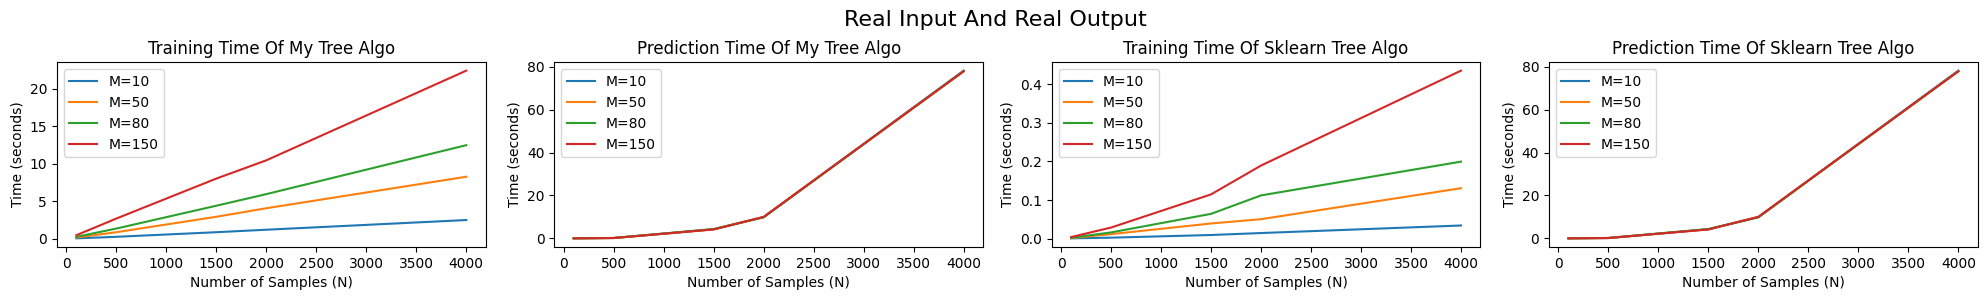

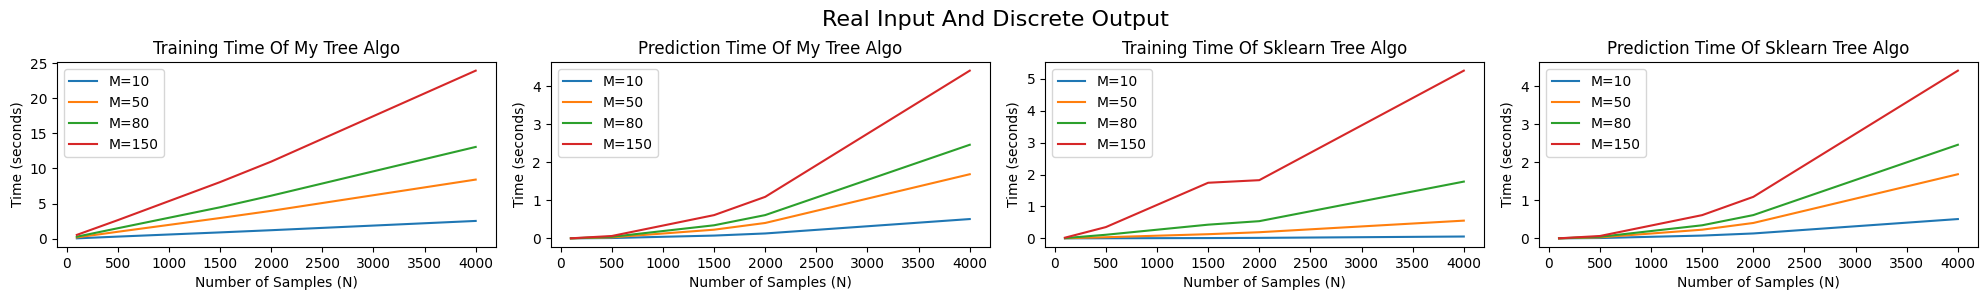

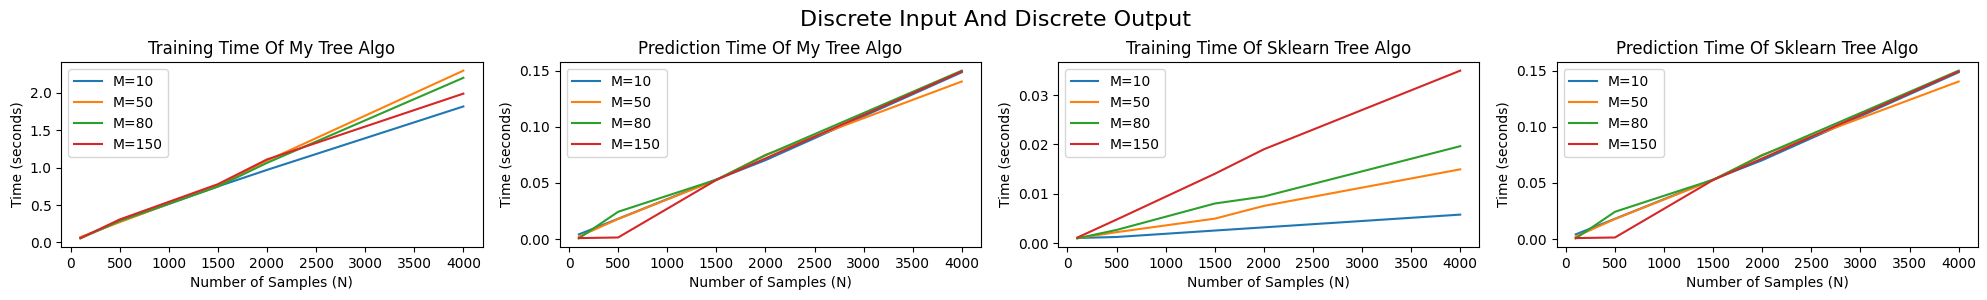

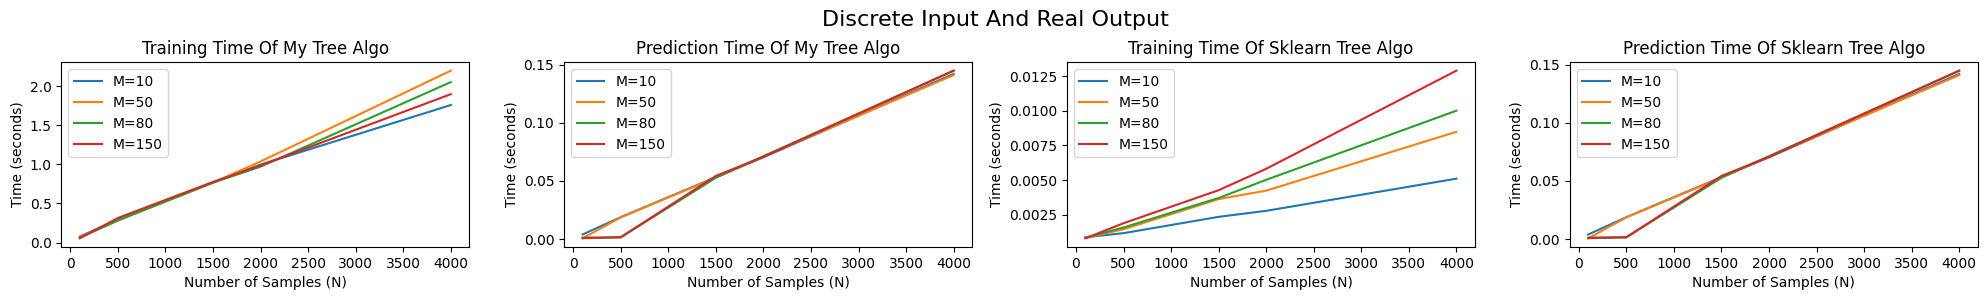

In [8]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
# from tree.base import DecisionTree  #run above "tree.py" cells that will bring them to this scope
# from metrics import *   # run above "metrics.py" cells that will bring them to this scope

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor


np.random.seed(42)
num_average_time = 100  # Number of times to run each experiment to calculate the average values


# Function to create fake data (take inspiration from usage.py)


# ...
# Function to calculate average time (and std) taken by fit() and predict() for different N and P for 4 different cases of DTs
# ...
# Function to plot the results
# ...
# Other functions
# ...
# Run the functions, Learn the DTs and Show the results/plots


def generate_real_input_real_output_data(N, M):
    #real Input real output
   
    X = pd.DataFrame(np.random.randn(N, M))
    y = pd.Series(np.random.randn(N))
    return X,y

def generate_real_input_discrete_output_data(N, M):
   # Real Input and Discrete Output

   X = pd.DataFrame(np.random.randn(N, M)) #temporary data
   y = pd.Series(np.random.randint(M, size=N), dtype="category")#temporary data 

   return X,y

def generate_discrete_input_discrete_output_data(N, M):
   # Discrete Input and Discrete Output

   X = pd.DataFrame({i: pd.Series(np.random.randint(M, size=N), dtype="category") for i in range(5)})
   y = pd.Series(np.random.randint(M, size=N), dtype="category")

   return X,y


def generate_discrete_input_real_output_data(N, M):
    # Discrete Input and Real Output

    X = pd.DataFrame({i: pd.Series(np.random.randint(M, size=N), dtype="category") for i in range(5)})
    y = pd.Series(np.random.randn(N))

    return X,y


# Function to perform the experiment and return times
def experiment(N, M,case,algo):#case  used here to define the case of decision tree
    X=None                   #algo=0 for my algo, algo=1 for sklearn algo
    y=None
    if(case==0):
        X, y = generate_real_input_real_output_data(N, M)#real input, real output
    elif(case==1):
        X, y = generate_real_input_discrete_output_data(N, M)#real input, disrete output
    elif(case==2):
        X, y = generate_discrete_input_discrete_output_data(N, M)#discrete input, discrete output
    elif(case==3):
        X, y = generate_discrete_input_real_output_data(N, M)#discrete input, real output


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Measure training time
    
    if(algo==0):#for my algo
        clf = DecisionTree("information_gain")  # Split based on Inf. Gain

        start_time = time.time()    
        clf.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Measure prediction time
        start_time = time.time()
        y_hat = clf.predict(X_test)
        prediction_time = time.time() - start_time

        return training_time, prediction_time

    elif(algo==1):#for sklearn algo
        if(case==0 or case==3):#for real outputs (regression problem)
            clf=DecisionTreeRegressor(random_state=42)
        else:#for classification outputs
            clf = DecisionTreeClassifier(random_state=42)

        start_time = time.time()    
        clf.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Measure prediction time
        start_time = time.time()
        y_hat = clf.predict(X_test)
        prediction_time = time.time() - start_time

        return training_time, prediction_time

def show_plot_by_varying_m_n(case):
    # Experiment with different N and M
    N_values = [100, 500, 1500, 2000, 4000]
    M_values = [10, 50, 80, 150]

    training_times_my_algo = []
    prediction_times_my_algo = []
    training_times_sklearn_algo = []
    prediction_times_sklearn_algo = []

    for N in N_values:
        for M in M_values:
            training_time, prediction_time = experiment(N, M,case,0)#0 is for my algo case
            training_times_my_algo.append((N, M, training_time))
            prediction_times_my_algo.append((N, M, prediction_time))

#finding time with sklearn tree algo in order to compare with ours
    for N in N_values:
        for M in M_values:
            training_time, prediction_time = experiment(N, M,case,1)#1 is for sklearn algo case
            training_times_sklearn_algo.append((N, M, training_time))
            prediction_times_sklearn_algo.append((N, M, prediction_time))
    


    plt.figure(figsize=(20, 10))
    if(case==0):
        plt.suptitle('Real Input And Real Output', fontsize=16)
    if(case==1):
        plt.suptitle('Real Input And Discrete Output', fontsize=16)
    if(case==2):
        plt.suptitle('Discrete Input And Discrete Output', fontsize=16)
    if(case==3):
        plt.suptitle('Discrete Input And Real Output', fontsize=16)


    #training time plot of my algo
    plt.subplot(4, 4, 1)
    for M in M_values:
        times = [t[2] for t in training_times_my_algo if t[1] == M]
        plt.plot(N_values, times, label=f'M={M}')
    plt.title("Training Time Of My Tree Algo")
    plt.xlabel("Number of Samples (N)")
    plt.ylabel("Time (seconds)")
    plt.legend()

    # Prediction time plot of my algo
    plt.subplot(4, 4, 2)
    for M in M_values:
        times = [t[2] for t in prediction_times_my_algo if t[1] == M]
        plt.plot(N_values, times, label=f'M={M}')
    plt.title("Prediction Time Of My Tree Algo")
    plt.xlabel("Number of Samples (N)")
    plt.ylabel("Time (seconds)")
    plt.legend()
    

    #training time plot of sklearn algo
    plt.subplot(4, 4, 3) #row, col, index
    for M in M_values:
        times = [t[2] for t in training_times_sklearn_algo if t[1] == M]
        plt.plot(N_values, times, label=f'M={M}')
    plt.title("Training Time Of Sklearn Tree Algo")
    plt.xlabel("Number of Samples (N)")
    plt.ylabel("Time (seconds)")
    plt.legend()

    # Prediction time plot of sklearnn algo
    plt.subplot(4, 4, 4)
    for M in M_values:
        times = [t[2] for t in prediction_times_my_algo if t[1] == M]
        plt.plot(N_values, times, label=f'M={M}')
    plt.title("Prediction Time Of Sklearn Tree Algo")
    plt.xlabel("Number of Samples (N)")
    plt.ylabel("Time (seconds)")
    plt.legend()

    plt.tight_layout()#adjust the layout

    plt.show()





#case=0 <-real input and real output 
#case=1 <- real input and discrete output
#case=2 <- discrete input and discrete output
#case=3 <-discrete input and real output

N=900
M=8


#differnt case no is passed in below function for different decision tree case 
show_plot_by_varying_m_n(0)
show_plot_by_varying_m_n(1)
show_plot_by_varying_m_n(2)
show_plot_by_varying_m_n(3)
